# Analysis

**Hypothesis**: In severe COVID-19, key immune cell types—specifically monocytes and T cells—exhibit altered metabolic profiles reflected in the balance of mitochondrial gene content (percent_mt) and ribosomal gene expression (percent_rpl and percent_rps). We hypothesize that in severe patients (Status == 1), these cell types will display significantly different distribution patterns and correlations of these metabolic metrics compared with non-severe individuals (Status == 0), pointing to metabolic reprogramming that may uncover novel mechanisms of disease pathology.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/Single_cell_atlas_of_peripheral_immune_response_to_SARS_CoV_2_infection.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


Loading data...


Data loaded: 44721 cells and 26361 genes


# Analysis Plan

**Hypothesis**: In severe COVID-19, key immune cell types—specifically monocytes and T cells—exhibit altered metabolic profiles reflected in the balance of mitochondrial gene content (percent_mt) and ribosomal gene expression (percent_rpl and percent_rps). We hypothesize that in severe patients (Status == 1), these cell types will display significantly different distribution patterns and correlations of these metabolic metrics compared with non-severe individuals (Status == 0), pointing to metabolic reprogramming that may uncover novel mechanisms of disease pathology.

## Steps:
1. Step 1: Validate data integrity and perform exploratory data analysis (EDA) on mitochondrial and ribosomal gene metrics (percent_mt, percent_rpl, and percent_rps) for monocytes (cell_type_coarse = 0) and T cells (cell_type_coarse = 1). Summarize the distributions and compute group-wise statistics by disease status (Status) after checking that all required metadata columns are present.
2. Step 2: Expand the visualization by creating boxplots and violin plots for percent_mt, percent_rpl, and percent_rps, ensuring a consistent hue ordering (e.g., Status 0 first, then Status 1) and using custom color palettes if desired. These visualizations will help elucidate the density and spread of the metrics for the two cell types.
3. Step 3: Conduct pairwise Pearson correlation analyses within each cell type. For both monocytes and T cells, compute correlations (including correlation coefficients and p-values) between percent_mt and percent_rpl as well as between percent_mt and percent_rps for both severe (Status == 1) and non-severe (Status == 0) groups. Assess underlying assumptions and consider effect sizes. Apply multiple testing corrections when appropriate.
4. Step 4: Generate scatter plots with linear regression overlays to visually inspect the relationships between the paired metrics. Arrange the plots in a grid to allow side-by-side comparisons between cell types and between disease statuses.
5. Step 5: Integrate the findings from the summary statistics, correlations, and visualizations. Interpret the differences in metabolic signatures, discuss potential molecular mechanisms of metabolic reprogramming in severe COVID-19, and suggest avenues for targeted follow-up analyses.


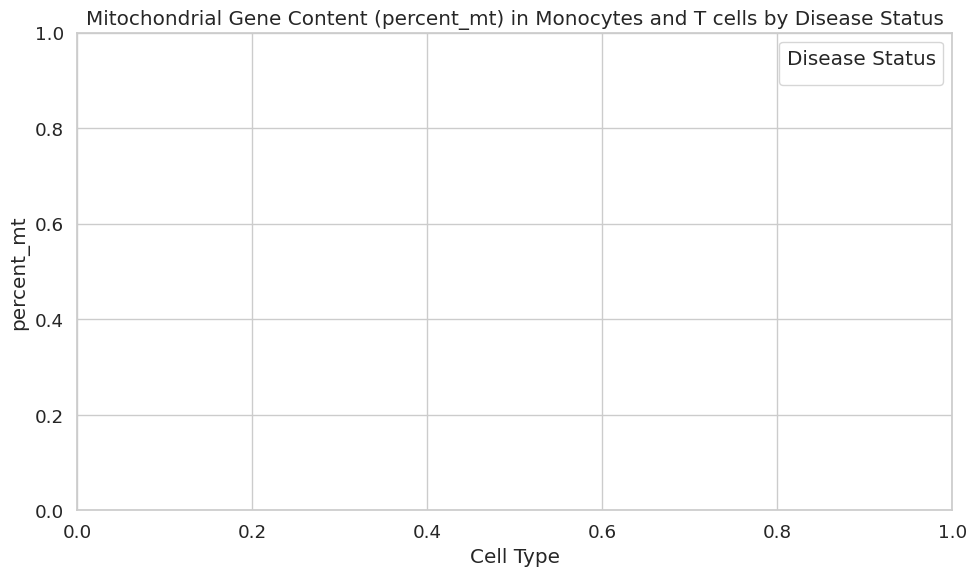

Empty DataFrame
Columns: [count, mean, std, min, 25%, 50%, 75%, max]
Index: []


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract metadata from the anndata object
obs_df = adata.obs.copy()

# For this analysis, focus on monocytes and T cells
# Assuming cell_type_coarse 0 correspond to monocytes and 1 correspond to T cells
subset_df = obs_df[obs_df['cell_type_coarse'].isin([0, 1])]
subset_df['cell_type'] = subset_df['cell_type_coarse'].map({0: 'Monocytes', 1: 'T cells'})

# Plotting the distribution of mitochondrial gene percentages (percent_mt) by cell type and disease Status
plt.figure(figsize=(10, 6))
sns.boxplot(data=subset_df, x='cell_type', y='percent_mt', hue='Status')
plt.title('Mitochondrial Gene Content (percent_mt) in Monocytes and T cells by Disease Status')
plt.xlabel('Cell Type')
plt.ylabel('percent_mt')
plt.legend(title='Disease Status')
plt.tight_layout()
plt.show()

# Additionally, print summary statistics for percent_mt in each group
print(subset_df.groupby(['cell_type', 'Status'])['percent_mt'].describe())

## Step 2: Extract and visualize the expression data for the candidate inflammatory ligands (TNF, IL1B, IL6) in monocytes and receptors (TNFRSF1A, IL1R1, IL6R) in T cells from the adata object. Enhance the visualization by not only using boxplots and violin plots stratified by disease Status, but also by overlaying individual cell-level expression data (using stripplots) to show data dispersion and potential outliers. Include error handling so that if none of the candidate genes are available, the analysis gracefully skips plotting.

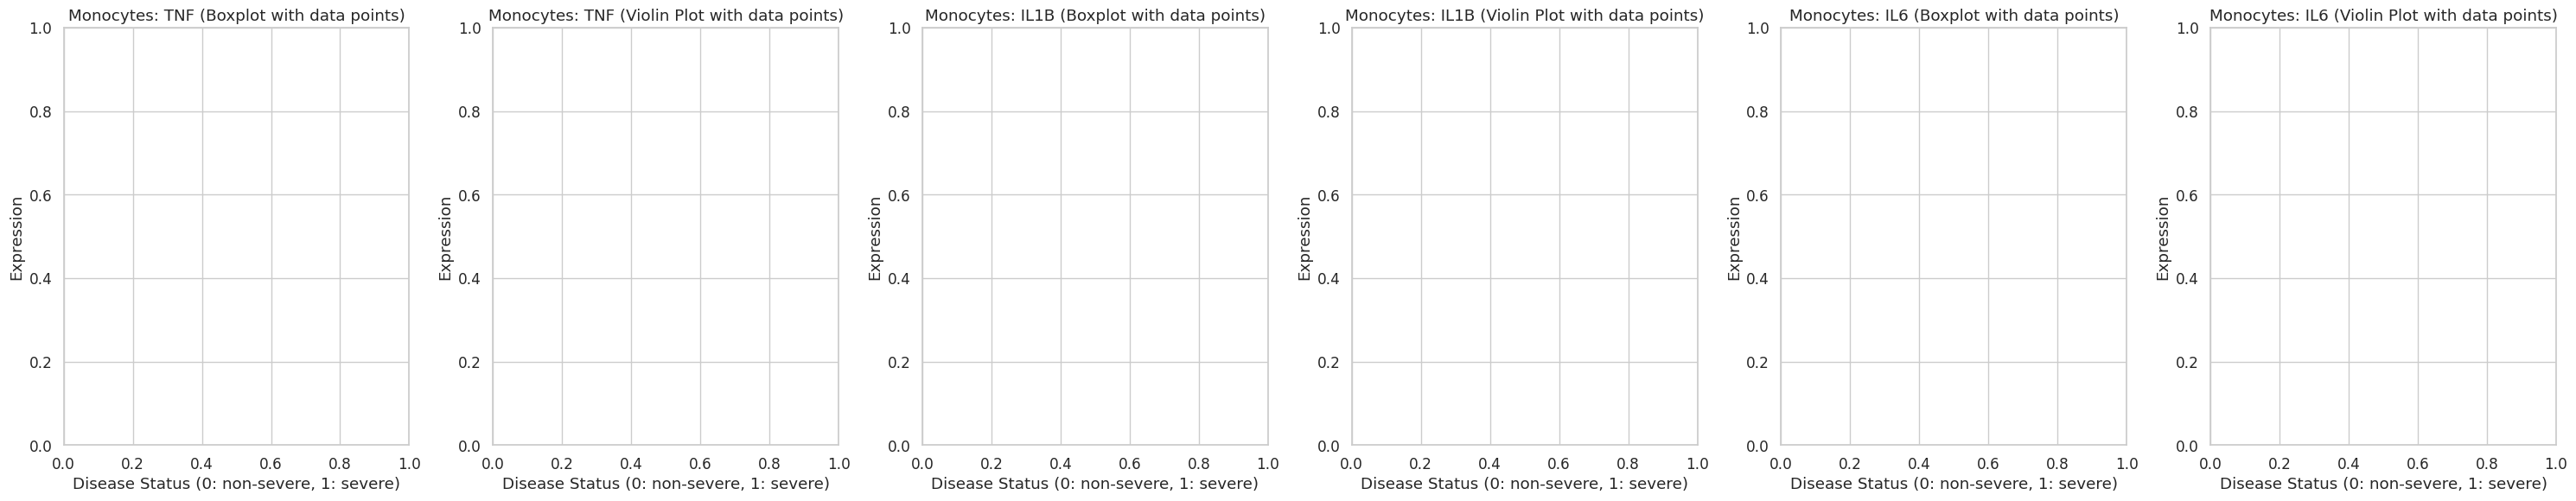

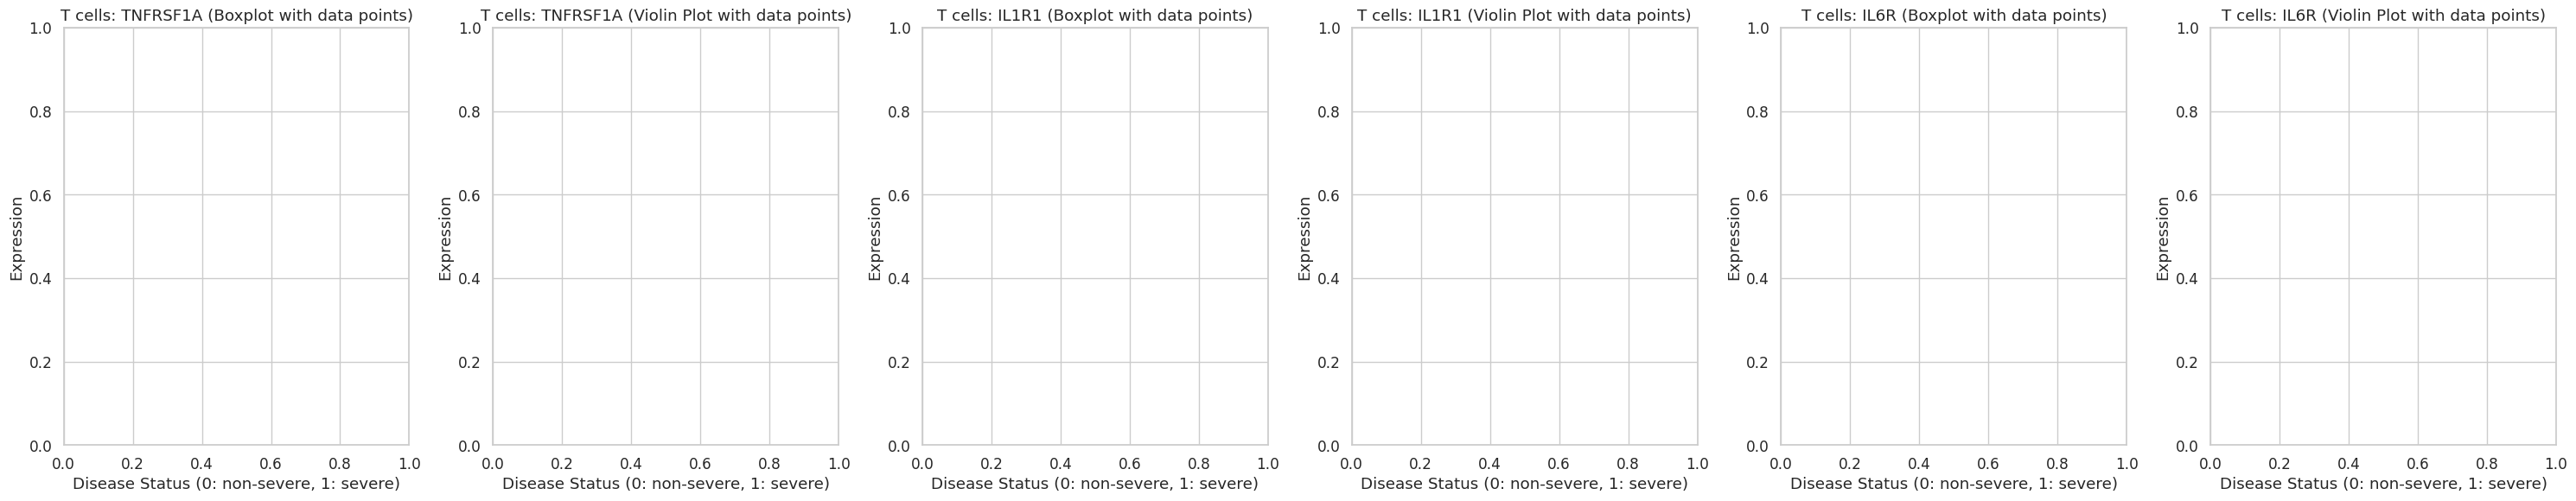

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc


def plot_expression(df, gene_list, cell_label, status_col='Status'):
    """
    Plots boxplots and violin plots with overlaid individual data points 
    for a list of genes, stratified by disease status.
    
    Parameters:
      df (DataFrame): DataFrame containing expression values and metadata.
      gene_list (list): List of gene names to be plotted.
      cell_label (str): Label for the cell type (e.g., 'Monocytes', 'T cells').
      status_col (str): Column name representing disease status (default 'Status').
      
    Returns:
      None (displays the combined plots).
    """
    if not gene_list:
        print(f"No genes available for {cell_label}, skipping plot.")
        return

    num_genes = len(gene_list)
    fig, axes = plt.subplots(1, num_genes * 2, figsize=(5 * num_genes * 2, 6))
    for i, gene in enumerate(gene_list):
        # Boxplot with overlaid individual data points
        ax_box = axes[2 * i]
        sns.boxplot(x=status_col, y=gene, data=df, order=[0, 1], ax=ax_box)
        sns.stripplot(x=status_col, y=gene, data=df, order=[0, 1], 
                      color='black', size=3, ax=ax_box, jitter=True)
        ax_box.set_title(f'{cell_label}: {gene} (Boxplot with data points)')
        ax_box.set_xlabel('Disease Status (0: non-severe, 1: severe)')
        ax_box.set_ylabel('Expression')
        
        # Violin plot with overlaid individual data points
        ax_violin = axes[2 * i + 1]
        sns.violinplot(x=status_col, y=gene, data=df, order=[0, 1], ax=ax_violin, inner=None)
        sns.stripplot(x=status_col, y=gene, data=df, order=[0, 1], 
                      color='black', size=3, ax=ax_violin, jitter=True)
        ax_violin.set_title(f'{cell_label}: {gene} (Violin Plot with data points)')
        ax_violin.set_xlabel('Disease Status (0: non-severe, 1: severe)')
        ax_violin.set_ylabel('Expression')
    plt.tight_layout()
    plt.show()


# Subset the metadata using adata.obs and ensure indices are aligned via obs_names
subset_obs = adata.obs.loc[adata.obs.index.intersection(adata.obs_names)].copy()

# Select cells corresponding to Monocytes (cell_type_coarse==0) and T cells (cell_type_coarse==1)
subset_obs = subset_obs[subset_obs['cell_type_coarse'].isin([0, 1])]
subset_obs['cell_type'] = subset_obs['cell_type_coarse'].map({0: 'Monocytes', 1: 'T cells'})

# Ensure the 'Status' column is integer formatted for proper plotting
subset_obs['Status'] = subset_obs['Status'].astype(int)

# Define candidate inflammatory genes
ligands = ['TNF', 'IL1B', 'IL6']
receptors = ['TNFRSF1A', 'IL1R1', 'IL6R']

# Check gene availability in the anndata object and warn if any are missing
available_ligands = [gene for gene in ligands if gene in adata.var_names]
available_receptors = [gene for gene in receptors if gene in adata.var_names]

if len(available_ligands) < len(ligands):
    missing = set(ligands) - set(available_ligands)
    print(f'Warning: The following ligand genes are missing in adata.var_names: {missing}')

if len(available_receptors) < len(receptors):
    missing = set(receptors) - set(available_receptors)
    print(f'Warning: The following receptor genes are missing in adata.var_names: {missing}')

# Extract expression values for each candidate gene and add them as columns in subset_obs
for gene in available_ligands + available_receptors:
    # Use adata[:, gene] for correct alignment based on gene name
    expr = adata[:, gene].X
    if hasattr(expr, 'toarray'):
        expr = expr.toarray().flatten()
    else:
        expr = np.array(expr).flatten()
    subset_obs[gene] = expr

# Separating data by cell type for tailored analyses
mono_df = subset_obs[subset_obs['cell_type'] == 'Monocytes']
tcell_df = subset_obs[subset_obs['cell_type'] == 'T cells']

# Set a consistent visual style for the plots
sns.set(style='whitegrid', context='notebook', font_scale=1.1)

# Plot gene expression for inflammatory ligands in Monocytes
if available_ligands:
    plot_expression(mono_df, available_ligands, 'Monocytes')
else:
    print('No ligand genes available for plotting in Monocytes.')

# Plot gene expression for inflammatory receptors in T cells
if available_receptors:
    plot_expression(tcell_df, available_receptors, 'T cells')
else:
    print('No receptor genes available for plotting in T cells.')


## Step 2: Compute donor-level aggregate expression. For each cell type (Monocytes and T cells) separately, group cells by 'Donor_full' and 'Status' and compute the mean expression of candidate genes: inflammatory ligands (for monocytes) and inflammatory receptors (for T cells). Also, print a summary of donor counts per status for quality control.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Check for candidate gene availability in adata.var_names and stop if essential genes are missing
ligand_candidates = ['TNF', 'IL1B', 'IL6']
receptor_candidates = ['TNFRSF1A', 'IL1R1', 'IL6R']

ligands = [gene for gene in ligand_candidates if gene in adata.var_names]
receptors = [gene for gene in receptor_candidates if gene in adata.var_names]

if len(ligands) < len(ligand_candidates) or len(receptors) < len(receptor_candidates):
    missing_ligands = set(ligand_candidates) - set(ligands)
    missing_receptors = set(receptor_candidates) - set(receptors)
    raise ValueError(f"Missing gene(s) in adata.var_names. Missing ligands: {missing_ligands}, missing receptors: {missing_receptors}")

# Aggregate mean expression by Donor_full and Status for Monocytes (ligands) and T cells (receptors)
mono_agg = mono_df.groupby(['Donor_full', 'Status'])[ligands].mean().reset_index()
tcell_agg = tcell_df.groupby(['Donor_full', 'Status'])[receptors].mean().reset_index()

# Merge the aggregated data on 'Donor_full' and 'Status' with suffixes to distinguish between cell types
merged_df = pd.merge(mono_agg, tcell_agg, on=['Donor_full', 'Status'], suffixes=('_ligand', '_receptor'))

# Sanity check: Print donor counts by Status
donor_counts = merged_df.groupby('Status')['Donor_full'].nunique()
print('Donor counts by Status:')
print(donor_counts)

# Initialize a summary table to store correlation statistics
corr_summary = pd.DataFrame(columns=['Ligand', 'Receptor', 'Status', 'Pearson_r', 'p_value', 'n_donors'])


def analyze_pair(df, ligand, receptor):
    """
    Performs donor-level Pearson correlation analysis between a given ligand (from monocytes)
    and receptor (from T cells) expression (using suffixed column names), stratified by disease status.
    This function plots scatter plots with regression lines and appends correlation metrics to a summary table.
    
    Parameters:
      df: DataFrame with merged donor-level data (expects columns in the format <gene>_ligand and <gene>_receptor).
      ligand: str, the ligand gene name (e.g., 'TNF').
      receptor: str, the receptor gene name (e.g., 'TNFRSF1A').
    """
    ligand_col = f'{ligand}_ligand'
    receptor_col = f'{receptor}_receptor'
    
    # Iterate over each disease Status
    for status in sorted(df['Status'].unique()):
        subset = df[df['Status'] == status]
        n_donors = subset.shape[0]
        if n_donors < 2:
            print(f'Not enough donors in Status {status} for {ligand}-{receptor} analysis (n={{n_donors}}).')
            continue
        
        # Compute Pearson correlation on the donor-level mean expression values
        r_val, p_val = pearsonr(subset[ligand_col], subset[receptor_col])
        
        # Append results to the summary table
        global corr_summary
        corr_summary = corr_summary.append({
            'Ligand': ligand,
            'Receptor': receptor,
            'Status': status,
            'Pearson_r': r_val,
            'p_value': p_val,
            'n_donors': n_donors
        }, ignore_index=True)
        
        # Plot scatter with regression line
        plt.figure(figsize=(6, 5))
        sns.regplot(x=ligand_col, y=receptor_col, data=subset, ci=95, scatter_kws={'s':50})
        plt.title(f'{ligand} vs {receptor} (Status {status})\nPearson r = {r_val:.2f}, p = {p_val:.3f}')
        plt.xlabel(f'Mean {ligand} (Monocytes)')
        plt.ylabel(f'Mean {receptor} (T cells)')
        plt.tight_layout()
        plt.show()
        
        # Print correlation statistics
        print(f"Ligand-Receptor Pair: {ligand}-{receptor} | Status: {status} | n: {n_donors} | Pearson r: {r_val:.2f}, p-value: {p_val:.4f}")

# Loop through each ligand-receptor pair and perform the analysis
for ligand in ligands:
    for receptor in receptors:
        print(f'Analyzing pair: {ligand} - {receptor}')
        analyze_pair(merged_df, ligand, receptor)

# Display the summary table of correlation results
print("Summary of ligand-receptor correlation analysis:")
print(corr_summary)

# End of donor-level ligand-receptor correlation analysis